In [1]:
import sys,os,os.path

sys.path.append("../../")   # cite IC from parent directory
                            # NOTE if you can't import IC stuff, its because of the
                            # above line
#sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
os.environ['ICTDIR']='/home/e78368jw/Documents/NEXT_CODE/IC'

import matplotlib.pyplot as plt
import pandas as pd
import numpy  as np
import tables as tb
import IC.invisible_cities.io.dst_io                           as     dstio
import IC.invisible_cities.io.mcinfo_io as mcio
from    IC.invisible_cities.core.core_functions   import shift_to_bin_centers
import iminuit,probfit

import scipy.special as special
from scipy.stats import skewnorm
from scipy.optimize import curve_fit

## Notebook to determine the best cut for satellite tracks and deal with the track shenanigans

- Find best track cuts
- Make sure track number is updated
- Re-introduce satellite track energy into highest E track

In [2]:
#adding here ROI
emin = 1.5
emax = 1.7

#### Load in data

In [3]:

# list of all files in a folder
folder_path = '../LPR_rerun/PORT_1a/prod/isaura/'
#file = f'isaura/isaura_10_228Th.h5'

file_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

# NOTE Break this section up, its annoying like this.
dfs = []
df_trs = []
df_ems = []
# create massive dataframe with all of them
for file in file_names:
    file_path = folder_path + file
    df = dstio.load_dst(file_path, 'Tracking', 'Tracks')
    dfs.append(df)
    # include MC particles (boooo takes ages)

    # collecting the correct components of the file, not exactly sure how this works
    df_ps = pd.read_hdf(file_path, 'MC/particles')
    #df_ps = df_ps[df_ps.creator_proc == 'conv']
    # collecting event map
    df_em = mcio.load_eventnumbermap(file_path).set_index('nexus_evt')
    df_trs.append(df_ps)
    df_ems.append(df_em)

tracks = pd.concat(dfs, axis=0, ignore_index=True)

particles = pd.concat(df_trs, ignore_index=True)
eventmap = pd.concat([dt for dt in df_ems])
# create particle list also

#### Plot track energy histogram

In [4]:
display(tracks.head(10))
print(tracks.columns)

,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
0,5080000,0,1.039447,106.957101,130,10660,4,368.675,160.675,334.439758,...,346.618662,395.709598,257.212595,386.899102,0.549273,0.021990,0.000000,9.857143,9.928571,4.809897
1,5080000,1,0.013352,4.809897,2,47,4,388.675,270.675,440.460083,...,441.936821,389.120948,279.638220,446.759552,0.013352,0.013352,0.013352,9.857143,9.928571,4.809897
2,5080000,2,0.010388,0.000000,1,65,4,378.675,254.675,408.962036,...,409.787137,381.749030,256.750470,409.787137,0.010388,0.010388,0.010388,9.857143,9.928571,4.809897
3,5080000,3,0.001319,0.000000,1,21,4,378.675,254.675,424.692047,...,424.692047,381.261911,256.890582,424.692047,0.001319,0.001319,0.001319,9.857143,9.928571,4.809897
4,5080002,0,0.962756,77.756812,74,5810,9,-87.325,359.675,612.663391,...,648.421388,-43.764823,403.787828,615.673530,0.306094,0.030088,0.000000,9.750000,9.571429,4.951324
5,5080002,1,0.731305,74.337640,72,4647,9,-98.325,411.675,604.282959,...,649.717506,-93.095078,423.334631,611.416833,0.375550,0.144682,0.000000,9.750000,9.571429,4.951324
6,5080002,2,0.168541,20.685177,10,850,9,127.675,353.675,498.257599,...,501.543143,131.322157,369.363285,505.352041,0.166143,0.145188,0.142790,9.750000,9.571429,4.951324
7,5080002,3,0.140927,58.630464,23,793,9,52.675,348.675,513.979492,...,516.101429,53.955545,349.802676,526.248103,0.088264,0.021532,0.000000,9.750000,9.571429,4.951324
8,5080002,4,0.074157,14.532390,5,290,9,-20.325,376.675,587.473511,...,594.815981,-4.176398,379.414310,588.386162,0.074157,0.074157,0.074157,9.750000,9.571429,4.951324
9,5080002,5,0.017627,10.776263,2,32,9,28.675,347.675,555.981140,...,560.994456,28.675000,360.638246,555.981140,0.017627,0.017627,0.017627,9.750000,9.571429,4.951324


Index(['event', 'trackID', 'energy', 'length', 'numb_of_voxels',
       'numb_of_hits', 'numb_of_tracks', 'x_min', 'y_min', 'z_min', 'r_min',
       'x_max', 'y_max', 'z_max', 'r_max', 'x_ave', 'y_ave', 'z_ave', 'r_ave',
       'extreme1_x', 'extreme1_y', 'extreme1_z', 'extreme2_x', 'extreme2_y',
       'extreme2_z', 'blob1_x', 'blob1_y', 'blob1_z', 'blob2_x', 'blob2_y',
       'blob2_z', 'eblob1', 'eblob2', 'ovlp_blob_energy', 'vox_size_x',
       'vox_size_y', 'vox_size_z'],
      dtype='object')


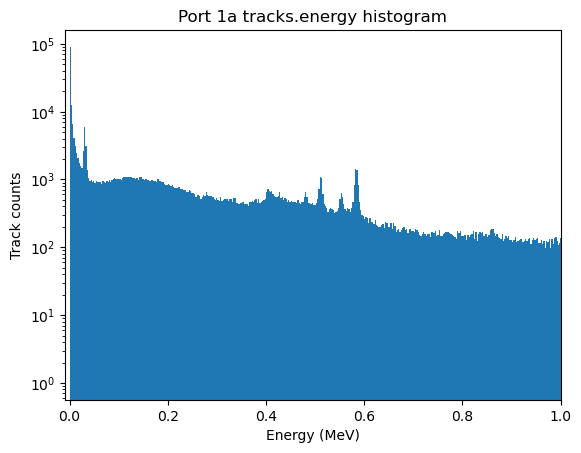

In [5]:
plt.hist(tracks.energy, bins = 1000)
plt.yscale('log')
plt.ylabel('Track counts')
plt.xlabel('Energy (MeV)')
plt.title('Port 1a tracks.energy histogram')
plt.xlim([-0.01,1])
plt.show()

#### Create function that removes these low energy events (50 keV)

first lets do it by hand with a couple of events to understand the moving pieces

In [20]:
tracks_test = tracks.copy(deep = True).head(1000)

In [21]:
display(tracks_test)

,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
0,5080000,0,1.039447,106.957101,130,10660,4,368.675,160.675,334.439758,...,346.618662,395.709598,257.212595,386.899102,0.549273,0.021990,0.000000,9.857143,9.928571,4.809897
1,5080000,1,0.013352,4.809897,2,47,4,388.675,270.675,440.460083,...,441.936821,389.120948,279.638220,446.759552,0.013352,0.013352,0.013352,9.857143,9.928571,4.809897
2,5080000,2,0.010388,0.000000,1,65,4,378.675,254.675,408.962036,...,409.787137,381.749030,256.750470,409.787137,0.010388,0.010388,0.010388,9.857143,9.928571,4.809897
3,5080000,3,0.001319,0.000000,1,21,4,378.675,254.675,424.692047,...,424.692047,381.261911,256.890582,424.692047,0.001319,0.001319,0.001319,9.857143,9.928571,4.809897
4,5080002,0,0.962756,77.756812,74,5810,9,-87.325,359.675,612.663391,...,648.421388,-43.764823,403.787828,615.673530,0.306094,0.030088,0.000000,9.750000,9.571429,4.951324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,5080604,0,1.014799,106.978601,166,11207,2,36.675,335.675,320.809387,...,323.727978,65.950941,341.752172,336.538019,0.409973,0.045099,0.000000,8.857143,10.000000,4.766646
996,5080604,1,0.000269,0.000000,1,9,2,57.675,452.675,331.267151,...,331.267151,59.325306,454.135669,331.267151,0.000269,0.000269,0.000269,8.857143,10.000000,4.766646
997,5080606,0,1.174219,126.211685,114,7691,8,-79.325,29.675,306.108185,...,329.279199,-68.345672,139.983753,347.700535,0.531185,0.073414,0.000000,9.888889,9.526316,4.999965
998,5080606,1,0.526598,65.743409,48,3201,8,-108.325,143.675,433.125549,...,473.385975,-82.557520,183.599946,438.373962,0.319182,0.149211,0.000000,9.888889,9.526316,4.999965


In [23]:
# take events with lower than 50 keV, 0.05 MeV
condition = (tracks_test.energy < 0.05)
display(tracks_test[condition])

,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
1,5080000,1,0.013352,4.809897,2,47,4,388.675,270.675,440.460083,...,441.936821,389.120948,279.638220,446.759552,0.013352,0.013352,0.013352,9.857143,9.928571,4.809897
2,5080000,2,0.010388,0.000000,1,65,4,378.675,254.675,408.962036,...,409.787137,381.749030,256.750470,409.787137,0.010388,0.010388,0.010388,9.857143,9.928571,4.809897
3,5080000,3,0.001319,0.000000,1,21,4,378.675,254.675,424.692047,...,424.692047,381.261911,256.890582,424.692047,0.001319,0.001319,0.001319,9.857143,9.928571,4.809897
9,5080002,5,0.017627,10.776263,2,32,9,28.675,347.675,555.981140,...,560.994456,28.675000,360.638246,555.981140,0.017627,0.017627,0.017627,9.750000,9.571429,4.951324
10,5080002,6,0.008122,0.000000,1,37,9,28.675,410.675,618.963989,...,620.147517,34.523942,415.043112,620.147517,0.008122,0.008122,0.008122,9.750000,9.571429,4.951324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
990,5080598,2,0.000313,0.000000,1,20,3,146.675,117.675,621.052490,...,621.052490,148.155570,120.367996,621.052490,0.000313,0.000313,0.000313,9.000000,9.571429,4.969967
992,5080600,1,0.000574,0.000000,1,34,2,394.675,-116.325,479.303741,...,479.303741,396.782227,-112.647530,479.303741,0.000574,0.000574,0.000574,9.500000,9.250000,4.966171
994,5080602,1,0.000568,0.000000,1,25,2,115.675,146.675,380.611603,...,380.611603,118.423483,149.020225,380.611603,0.000568,0.000568,0.000568,9.700000,9.000000,4.859750
996,5080604,1,0.000269,0.000000,1,9,2,57.675,452.675,331.267151,...,331.267151,59.325306,454.135669,331.267151,0.000269,0.000269,0.000269,8.857143,10.000000,4.766646


In [26]:
# collect the sums of these energies, and add them to the first track in the event
summed_df = tracks_test[condition].groupby('event')['energy'].sum().reset_index()
print(summed_df)

       event    energy
0    5080000  0.025059
1    5080002  0.027931
2    5080004  0.001505
3    5080008  0.030160
4    5080010  0.026443
..       ...       ...
203  5080598  0.000313
204  5080600  0.000574
205  5080602  0.000568
206  5080604  0.000269
207  5080606  0.016731

[208 rows x 2 columns]


In [31]:
# merge these as a new column
merged_df = pd.merge(tracks_test, summed_df, on='event', suffixes=('', '_sum'))
display(merged_df)

,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z,energy_sum
0,5080000,0,1.039447,106.957101,130,10660,4,368.675,160.675,334.439758,...,395.709598,257.212595,386.899102,0.549273,0.021990,0.000000,9.857143,9.928571,4.809897,0.025059
1,5080000,1,0.013352,4.809897,2,47,4,388.675,270.675,440.460083,...,389.120948,279.638220,446.759552,0.013352,0.013352,0.013352,9.857143,9.928571,4.809897,0.025059
2,5080000,2,0.010388,0.000000,1,65,4,378.675,254.675,408.962036,...,381.749030,256.750470,409.787137,0.010388,0.010388,0.010388,9.857143,9.928571,4.809897,0.025059
3,5080000,3,0.001319,0.000000,1,21,4,378.675,254.675,424.692047,...,381.261911,256.890582,424.692047,0.001319,0.001319,0.001319,9.857143,9.928571,4.809897,0.025059
4,5080002,0,0.962756,77.756812,74,5810,9,-87.325,359.675,612.663391,...,-43.764823,403.787828,615.673530,0.306094,0.030088,0.000000,9.750000,9.571429,4.951324,0.027931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
857,5080604,0,1.014799,106.978601,166,11207,2,36.675,335.675,320.809387,...,65.950941,341.752172,336.538019,0.409973,0.045099,0.000000,8.857143,10.000000,4.766646,0.000269
858,5080604,1,0.000269,0.000000,1,9,2,57.675,452.675,331.267151,...,59.325306,454.135669,331.267151,0.000269,0.000269,0.000269,8.857143,10.000000,4.766646,0.000269
859,5080606,0,1.174219,126.211685,114,7691,8,-79.325,29.675,306.108185,...,-68.345672,139.983753,347.700535,0.531185,0.073414,0.000000,9.888889,9.526316,4.999965,0.016731
860,5080606,1,0.526598,65.743409,48,3201,8,-108.325,143.675,433.125549,...,-82.557520,183.599946,438.373962,0.319182,0.149211,0.000000,9.888889,9.526316,4.999965,0.016731


In [32]:
# add this summed energy to first column
merged_df['energy'] = merged_df.apply(lambda row: (row['energy'] + row['energy_sum']) if row.name == merged_df[merged_df['event'] == row['event']].index[0] else row['energy'], axis=1)
display(merged_df)


,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z,energy_sum
0,5080000,0,1.064505,106.957101,130,10660,4,368.675,160.675,334.439758,...,395.709598,257.212595,386.899102,0.549273,0.021990,0.000000,9.857143,9.928571,4.809897,0.025059
1,5080000,1,0.013352,4.809897,2,47,4,388.675,270.675,440.460083,...,389.120948,279.638220,446.759552,0.013352,0.013352,0.013352,9.857143,9.928571,4.809897,0.025059
2,5080000,2,0.010388,0.000000,1,65,4,378.675,254.675,408.962036,...,381.749030,256.750470,409.787137,0.010388,0.010388,0.010388,9.857143,9.928571,4.809897,0.025059
3,5080000,3,0.001319,0.000000,1,21,4,378.675,254.675,424.692047,...,381.261911,256.890582,424.692047,0.001319,0.001319,0.001319,9.857143,9.928571,4.809897,0.025059
4,5080002,0,0.990687,77.756812,74,5810,9,-87.325,359.675,612.663391,...,-43.764823,403.787828,615.673530,0.306094,0.030088,0.000000,9.750000,9.571429,4.951324,0.027931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
857,5080604,0,1.015068,106.978601,166,11207,2,36.675,335.675,320.809387,...,65.950941,341.752172,336.538019,0.409973,0.045099,0.000000,8.857143,10.000000,4.766646,0.000269
858,5080604,1,0.000269,0.000000,1,9,2,57.675,452.675,331.267151,...,59.325306,454.135669,331.267151,0.000269,0.000269,0.000269,8.857143,10.000000,4.766646,0.000269
859,5080606,0,1.190950,126.211685,114,7691,8,-79.325,29.675,306.108185,...,-68.345672,139.983753,347.700535,0.531185,0.073414,0.000000,9.888889,9.526316,4.999965,0.016731
860,5080606,1,0.526598,65.743409,48,3201,8,-108.325,143.675,433.125549,...,-82.557520,183.599946,438.373962,0.319182,0.149211,0.000000,9.888889,9.526316,4.999965,0.016731


In [33]:
# drop energy sum

result_df = merged_df.drop('energy_sum', axis = 1)
display(result_df)

,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
0,5080000,0,1.064505,106.957101,130,10660,4,368.675,160.675,334.439758,...,346.618662,395.709598,257.212595,386.899102,0.549273,0.021990,0.000000,9.857143,9.928571,4.809897
1,5080000,1,0.013352,4.809897,2,47,4,388.675,270.675,440.460083,...,441.936821,389.120948,279.638220,446.759552,0.013352,0.013352,0.013352,9.857143,9.928571,4.809897
2,5080000,2,0.010388,0.000000,1,65,4,378.675,254.675,408.962036,...,409.787137,381.749030,256.750470,409.787137,0.010388,0.010388,0.010388,9.857143,9.928571,4.809897
3,5080000,3,0.001319,0.000000,1,21,4,378.675,254.675,424.692047,...,424.692047,381.261911,256.890582,424.692047,0.001319,0.001319,0.001319,9.857143,9.928571,4.809897
4,5080002,0,0.990687,77.756812,74,5810,9,-87.325,359.675,612.663391,...,648.421388,-43.764823,403.787828,615.673530,0.306094,0.030088,0.000000,9.750000,9.571429,4.951324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
857,5080604,0,1.015068,106.978601,166,11207,2,36.675,335.675,320.809387,...,323.727978,65.950941,341.752172,336.538019,0.409973,0.045099,0.000000,8.857143,10.000000,4.766646
858,5080604,1,0.000269,0.000000,1,9,2,57.675,452.675,331.267151,...,331.267151,59.325306,454.135669,331.267151,0.000269,0.000269,0.000269,8.857143,10.000000,4.766646
859,5080606,0,1.190950,126.211685,114,7691,8,-79.325,29.675,306.108185,...,329.279199,-68.345672,139.983753,347.700535,0.531185,0.073414,0.000000,9.888889,9.526316,4.999965
860,5080606,1,0.526598,65.743409,48,3201,8,-108.325,143.675,433.125549,...,473.385975,-82.557520,183.599946,438.373962,0.319182,0.149211,0.000000,9.888889,9.526316,4.999965


In [36]:
# then remove all tracks below the energy threshold
condition_upper = (result_df.energy > 0.05)
remove_low_E = result_df[condition_upper]

display(remove_low_E)

,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
0,5080000,0,1.064505,106.957101,130,10660,4,368.675,160.675,334.439758,...,346.618662,395.709598,257.212595,386.899102,0.549273,0.021990,0.000000,9.857143,9.928571,4.809897
4,5080002,0,0.990687,77.756812,74,5810,9,-87.325,359.675,612.663391,...,648.421388,-43.764823,403.787828,615.673530,0.306094,0.030088,0.000000,9.750000,9.571429,4.951324
5,5080002,1,0.731305,74.337640,72,4647,9,-98.325,411.675,604.282959,...,649.717506,-93.095078,423.334631,611.416833,0.375550,0.144682,0.000000,9.750000,9.571429,4.951324
6,5080002,2,0.168541,20.685177,10,850,9,127.675,353.675,498.257599,...,501.543143,131.322157,369.363285,505.352041,0.166143,0.145188,0.142790,9.750000,9.571429,4.951324
7,5080002,3,0.140927,58.630464,23,793,9,52.675,348.675,513.979492,...,516.101429,53.955545,349.802676,526.248103,0.088264,0.021532,0.000000,9.750000,9.571429,4.951324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
853,5080600,0,0.423214,35.156585,27,4326,2,379.675,-88.325,472.019440,...,475.305450,398.674305,-56.112175,489.466235,0.363977,0.106160,0.047908,9.500000,9.250000,4.966171
855,5080602,0,0.580346,75.802730,81,5682,2,145.675,105.675,332.339783,...,382.641351,191.431382,133.717747,335.539057,0.359829,0.052415,0.000000,9.700000,9.000000,4.859750
857,5080604,0,1.015068,106.978601,166,11207,2,36.675,335.675,320.809387,...,323.727978,65.950941,341.752172,336.538019,0.409973,0.045099,0.000000,8.857143,10.000000,4.766646
859,5080606,0,1.190950,126.211685,114,7691,8,-79.325,29.675,306.108185,...,329.279199,-68.345672,139.983753,347.700535,0.531185,0.073414,0.000000,9.888889,9.526316,4.999965


In [40]:
# count the number of events identified with unique event, and change numb_of_tracks to reflect this
event_counts = remove_low_E['event'].value_counts(sort = False)
display(event_counts)

5080000    1
5080002    5
5080004    1
5080008    2
5080010    2
          ..
5080598    2
5080600    1
5080602    1
5080604    1
5080606    2
Name: event, Length: 208, dtype: int64

In [44]:
# apply this to numb_of_tracks
remove_low_E['numb_of_tracks'] = remove_low_E['event'].map(event_counts)

display(remove_low_E)

/home/e78368jw/anaconda3/envs/IC-3.8-2022-04-13/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
0,5080000,0,1.064505,106.957101,130,10660,1,368.675,160.675,334.439758,...,346.618662,395.709598,257.212595,386.899102,0.549273,0.021990,0.000000,9.857143,9.928571,4.809897
4,5080002,0,0.990687,77.756812,74,5810,5,-87.325,359.675,612.663391,...,648.421388,-43.764823,403.787828,615.673530,0.306094,0.030088,0.000000,9.750000,9.571429,4.951324
5,5080002,1,0.731305,74.337640,72,4647,5,-98.325,411.675,604.282959,...,649.717506,-93.095078,423.334631,611.416833,0.375550,0.144682,0.000000,9.750000,9.571429,4.951324
6,5080002,2,0.168541,20.685177,10,850,5,127.675,353.675,498.257599,...,501.543143,131.322157,369.363285,505.352041,0.166143,0.145188,0.142790,9.750000,9.571429,4.951324
7,5080002,3,0.140927,58.630464,23,793,5,52.675,348.675,513.979492,...,516.101429,53.955545,349.802676,526.248103,0.088264,0.021532,0.000000,9.750000,9.571429,4.951324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
853,5080600,0,0.423214,35.156585,27,4326,1,379.675,-88.325,472.019440,...,475.305450,398.674305,-56.112175,489.466235,0.363977,0.106160,0.047908,9.500000,9.250000,4.966171
855,5080602,0,0.580346,75.802730,81,5682,1,145.675,105.675,332.339783,...,382.641351,191.431382,133.717747,335.539057,0.359829,0.052415,0.000000,9.700000,9.000000,4.859750
857,5080604,0,1.015068,106.978601,166,11207,1,36.675,335.675,320.809387,...,323.727978,65.950941,341.752172,336.538019,0.409973,0.045099,0.000000,8.857143,10.000000,4.766646
859,5080606,0,1.190950,126.211685,114,7691,2,-79.325,29.675,306.108185,...,329.279199,-68.345672,139.983753,347.700535,0.531185,0.073414,0.000000,9.888889,9.526316,4.999965


In [6]:
def remove_low_E_events(df, energy_limit = 0.05):
    '''
    Remove low energy tracks, add their energy back to the first
    track and then update 'numb_of_tracks' to be up to date
    '''

    tracks_test = df.copy(deep=True)

    # take events with lower than 50 keV, 0.05 MeV
    condition = (tracks_test.energy < energy_limit)
    summed_df = tracks_test[condition].groupby('event')['energy'].sum().reset_index()

    # merge these as a new column
    merged_df = pd.merge(tracks_test, summed_df, on='event', suffixes=('', '_sum'))

    # add this summed energy to first column
    merged_df['energy'] = merged_df.apply(lambda row: (row['energy'] + row['energy_sum']) if row.name == merged_df[merged_df['event'] == row['event']].index[0] else row['energy'], axis=1)

    # drop energy sum column
    result_df = merged_df.drop('energy_sum', axis = 1)

    # then remove all tracks below the energy threshold
    condition_upper = (result_df.energy > energy_limit)
    remove_low_E = result_df[condition_upper]

    # count the number of events identified with unique event, and change numb_of_tracks to reflect this
    event_counts = remove_low_E['event'].value_counts(sort = False)

    # apply this to numb_of_tracks
    remove_low_E['numb_of_tracks'] = remove_low_E['event'].map(event_counts)

    return remove_low_E

In [7]:
# test the function
tracks_test = tracks.copy(deep = True).head(1000)

test_output_function = remove_low_E_events(tracks_test)
display(test_output_function)

/tmp/ipykernel_26717/261361389.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remove_low_E['numb_of_tracks'] = remove_low_E['event'].map(event_counts)


,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
0,5080000,0,1.064505,106.957101,130,10660,1,368.675,160.675,334.439758,...,346.618662,395.709598,257.212595,386.899102,0.549273,0.021990,0.000000,9.857143,9.928571,4.809897
4,5080002,0,0.990687,77.756812,74,5810,5,-87.325,359.675,612.663391,...,648.421388,-43.764823,403.787828,615.673530,0.306094,0.030088,0.000000,9.750000,9.571429,4.951324
5,5080002,1,0.731305,74.337640,72,4647,5,-98.325,411.675,604.282959,...,649.717506,-93.095078,423.334631,611.416833,0.375550,0.144682,0.000000,9.750000,9.571429,4.951324
6,5080002,2,0.168541,20.685177,10,850,5,127.675,353.675,498.257599,...,501.543143,131.322157,369.363285,505.352041,0.166143,0.145188,0.142790,9.750000,9.571429,4.951324
7,5080002,3,0.140927,58.630464,23,793,5,52.675,348.675,513.979492,...,516.101429,53.955545,349.802676,526.248103,0.088264,0.021532,0.000000,9.750000,9.571429,4.951324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
853,5080600,0,0.423214,35.156585,27,4326,1,379.675,-88.325,472.019440,...,475.305450,398.674305,-56.112175,489.466235,0.363977,0.106160,0.047908,9.500000,9.250000,4.966171
855,5080602,0,0.580346,75.802730,81,5682,1,145.675,105.675,332.339783,...,382.641351,191.431382,133.717747,335.539057,0.359829,0.052415,0.000000,9.700000,9.000000,4.859750
857,5080604,0,1.015068,106.978601,166,11207,1,36.675,335.675,320.809387,...,323.727978,65.950941,341.752172,336.538019,0.409973,0.045099,0.000000,8.857143,10.000000,4.766646
859,5080606,0,1.190950,126.211685,114,7691,2,-79.325,29.675,306.108185,...,329.279199,-68.345672,139.983753,347.700535,0.531185,0.073414,0.000000,9.888889,9.526316,4.999965


In [10]:
# test on all tracks

test_output_function_full = remove_low_E_events(tracks)
display(test_output_function_full)

/tmp/ipykernel_26717/261361389.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remove_low_E['numb_of_tracks'] = remove_low_E['event'].map(event_counts)


,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
0,5080000,0,1.064505,106.957101,130,10660,1,368.675,160.675,334.439758,...,346.618662,395.709598,257.212595,386.899102,0.549273,0.021990,0.000000,9.857143,9.928571,4.809897
4,5080002,0,0.990687,77.756812,74,5810,5,-87.325,359.675,612.663391,...,648.421388,-43.764823,403.787828,615.673530,0.306094,0.030088,0.000000,9.750000,9.571429,4.951324
5,5080002,1,0.731305,74.337640,72,4647,5,-98.325,411.675,604.282959,...,649.717506,-93.095078,423.334631,611.416833,0.375550,0.144682,0.000000,9.750000,9.571429,4.951324
6,5080002,2,0.168541,20.685177,10,850,5,127.675,353.675,498.257599,...,501.543143,131.322157,369.363285,505.352041,0.166143,0.145188,0.142790,9.750000,9.571429,4.951324
7,5080002,3,0.140927,58.630464,23,793,5,52.675,348.675,513.979492,...,516.101429,53.955545,349.802676,526.248103,0.088264,0.021532,0.000000,9.750000,9.571429,4.951324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273438,4060706,0,0.404530,25.853993,18,3097,2,303.675,329.675,374.358429,...,377.331447,317.462977,339.839160,395.508889,0.390823,0.371626,0.363359,9.981481,9.880000,4.910067
273439,4060706,1,0.067269,14.044372,4,676,2,-183.325,135.675,490.888611,...,494.903593,-173.294545,143.122722,493.780362,0.067269,0.067269,0.067269,9.981481,9.880000,4.910067
273442,4060708,0,0.317252,20.000000,7,2000,2,143.675,270.675,792.234558,...,798.473605,157.535769,287.916382,801.044561,0.283229,0.282732,0.282193,10.000000,10.000000,4.978625
273443,4060708,1,0.121964,11.170797,3,825,2,194.675,346.675,305.074768,...,307.543623,199.229377,361.048733,310.254849,0.121964,0.121964,0.121964,10.000000,10.000000,4.978625


In [55]:
display(tracks)

,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
0,5080000,0,1.039447,106.957101,130,10660,4,368.675,160.675,334.439758,...,346.618662,395.709598,257.212595,386.899102,0.549273,0.021990,0.000000,9.857143,9.928571,4.809897
1,5080000,1,0.013352,4.809897,2,47,4,388.675,270.675,440.460083,...,441.936821,389.120948,279.638220,446.759552,0.013352,0.013352,0.013352,9.857143,9.928571,4.809897
2,5080000,2,0.010388,0.000000,1,65,4,378.675,254.675,408.962036,...,409.787137,381.749030,256.750470,409.787137,0.010388,0.010388,0.010388,9.857143,9.928571,4.809897
3,5080000,3,0.001319,0.000000,1,21,4,378.675,254.675,424.692047,...,424.692047,381.261911,256.890582,424.692047,0.001319,0.001319,0.001319,9.857143,9.928571,4.809897
4,5080002,0,0.962756,77.756812,74,5810,9,-87.325,359.675,612.663391,...,648.421388,-43.764823,403.787828,615.673530,0.306094,0.030088,0.000000,9.750000,9.571429,4.951324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328458,4060710,0,0.572125,48.927675,59,7484,1,314.675,294.675,522.397217,...,525.821166,349.089849,320.664750,551.769409,0.235944,0.037322,0.000000,9.833333,9.428571,4.456444
328459,4060712,0,0.861342,87.723252,103,6380,4,5.675,415.675,335.498718,...,338.256397,25.904968,465.826742,400.302053,0.169192,0.042754,0.000000,9.500000,8.875000,4.836665
328460,4060712,1,0.026480,4.836665,2,79,4,22.675,478.675,414.213104,...,416.042900,24.629322,478.906839,420.872278,0.026480,0.026480,0.026480,9.500000,8.875000,4.836665
328461,4060712,2,0.001016,8.875000,2,28,4,-6.325,440.675,354.365692,...,354.365692,-3.942128,443.310643,354.365692,0.001016,0.001016,0.001016,9.500000,8.875000,4.836665


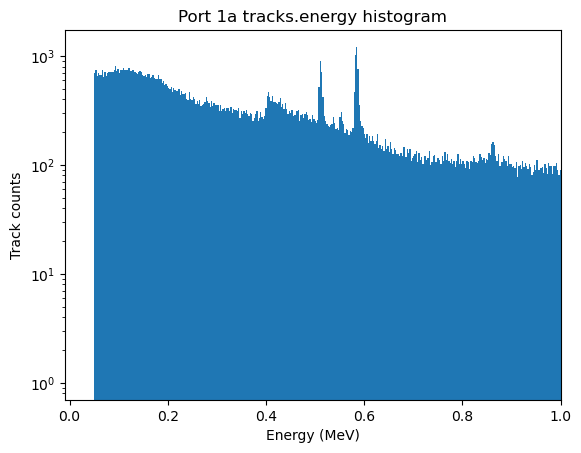

In [11]:
plt.hist(test_output_function_full.energy, bins = 1000)
plt.yscale('log')
plt.ylabel('Track counts')
plt.xlabel('Energy (MeV)')
plt.title('Port 1a tracks.energy histogram')
plt.xlim([-0.01,1])
plt.show()

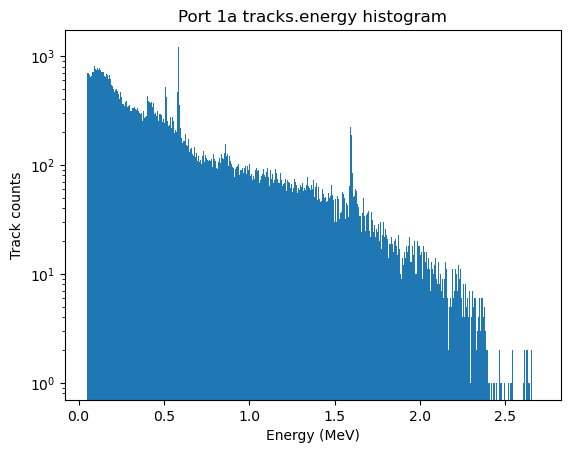

In [12]:
plt.hist(test_output_function_full.energy, bins = 1000)
plt.yscale('log')
plt.ylabel('Track counts')
plt.xlabel('Energy (MeV)')
plt.title('Port 1a tracks.energy histogram')
plt.show()

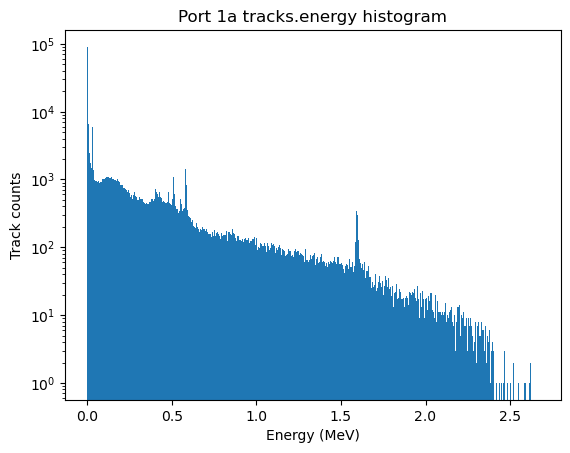

In [13]:
plt.hist(tracks.energy, bins = 1000)
plt.yscale('log')
plt.ylabel('Track counts')
plt.xlabel('Energy (MeV)')
plt.title('Port 1a tracks.energy histogram')
plt.show()